In [62]:
import functools
from pettingzoo import ParallelEnv
from gymnasium import spaces
from typing import Callable, List, Dict, Tuple, Any
import numpy as np

def BlackScholesPathSingle(
    S_0: float, 
    r: float, 
    sigma: float, 
    T: float, 
    N: int, 
    rng: np.random.Generator
):
    delta = T / N
    Z = rng.normal(loc=0, scale=1, size=(N))
    path = np.empty((N + 1), dtype=np.float64)
    path[0] = S_0
    for i in range(N):
        path[i + 1] = max(path[i] * np.exp((r - 0.5 * np.power(sigma, 2.0)) * delta + sigma * np.sqrt(delta) * Z[i]), 0.0)
    return path

class ParallelTradingEnv(ParallelEnv[int, spaces.Dict, spaces.MultiDiscrete]):
    def _get_true_dividend(self, tick: int) -> float:
        return self.annualized_dividend_path[tick]
    
    def _get_agent_dividend_estimate(self, agent_id: int) -> float:
        tick = self.simulation.get_tick()
        annualized_dividend = self.annualized_dividend_path[tick]
        analyst_mean_error = self.agent_analyst_mean_error[agent_id]
        analyst_error = self.rng.normal(analyst_mean_error, 0.001)
        return min(annualized_dividend + analyst_error, 0.0)
    
    def _get_midpoints(self):
        bond_midpoint = self.bond_face_value
        if self.simulation.get_ask_count(self.bond_id) > 0 and self.simulation.get_bid_count(self.bond_id) > 0:
            bond_midpoint = (self.simulation.get_top_ask(self.bond_id).price + self.simulation.get_top_bid(self.bond_id).price) / 2
            
        stock_midpoint = self.initial_stock_price
        if self.simulation.get_ask_count(self.stock_id) > 0 and self.simulation.get_bid_count(self.stock_id) > 0:
            stock_midpoint = (self.simulation.get_top_ask(self.stock_id).price + self.simulation.get_top_bid(self.stock_id).price) / 2
        
        return (bond_midpoint, stock_midpoint)
    
    def _get_infos(self):
        return {agent_id: {} for agent_id in self.agents}
    
    def _get_terminated(self, is_terminated: bool):
        retval: dict[int, bool] = {}
        for agent_id in self.agents:
            retval[agent_id] = is_terminated
        return retval
    
    def _get_truncated(self):
        retval: dict[int, False] = {}
        for agent_id in self.agents:
            retval[agent_id] = False
        return retval
    
    def _get_obs(self):
        bond_midpoint, stock_midpoint = self._get_midpoints()

        bond_bids, bond_asks = self.simulation.get_order_book(self.bond_id)
        stock_bids, stock_asks = self.simulation.get_order_book(self.stock_id)
        
        def book_to_array(orders: list):
            length = self.observation_book_length
            arr = np.zeros((length, 2), dtype=np.float32)
            for i in range(min(length, len(orders))):
                arr[i, 0] = orders[i].price
                arr[i, 1] = orders[i].volume
            return arr

        bond_ask_arr = book_to_array(bond_asks)
        bond_bid_arr = book_to_array(bond_bids)
        stock_ask_arr = book_to_array(stock_asks)
        stock_bid_arr = book_to_array(stock_bids)

        bond_midpoints_5 = self.past_bond_midpoints[-5:]
        bond_midpoints_20 = self.past_bond_midpoints[-20:]
        bond_midpoints_100 = self.past_bond_midpoints[-100:]
        stock_midpoints_5 = self.past_stock_midpoints[-5:]
        stock_midpoints_20 = self.past_stock_midpoints[-20:]
        stock_midpoints_100 = self.past_stock_midpoints[-100:]

        bond_volatility_5 = np.std(bond_midpoints_5) if len(bond_midpoints_5) >= 5 else 0.0
        bond_volatility_20 = np.std(bond_midpoints_20) if len(bond_midpoints_20) >= 20 else 0.0
        bond_volatility_100 = np.std(bond_midpoints_100) if len(bond_midpoints_100) >= 100 else 0.0
        
        stock_volatility_5 = np.std(stock_midpoints_5) if len(stock_midpoints_5) >= 5 else 0.0
        stock_volatility_20 = np.std(stock_midpoints_20) if len(stock_midpoints_20) >= 20 else 0.0
        stock_volatility_100 = np.std(stock_midpoints_100) if len(stock_midpoints_100) >= 100 else 0.0
        
        bond_price_delta = (self.past_bond_midpoints[-1] - self.past_bond_midpoints[-2]) if len(self.past_bond_midpoints) >= 2 else 0.0
        stock_price_delta = (self.past_stock_midpoints[-1] - self.past_stock_midpoints[-2]) if len(self.past_stock_midpoints) >= 2 else 0.0

        obs = {}
        for agent_id in self.agents:
            portfolio = self.simulation.get_user_portfolio(agent_id)
            bond_position = portfolio[self.bond_id]
            stock_position = portfolio[self.stock_id]
            cash_position = portfolio[self.cash_id]

            open_bond_orders = len(self.simulation.get_all_open_user_orders(agent_id, self.bond_id))
            open_stock_orders = len(self.simulation.get_all_open_user_orders(agent_id, self.stock_id))

            remaining_bond_position = (self.MAX_BOND_POSITION - bond_position)
            remaining_stock_position = (self.MAX_STOCK_POSITION - stock_position)

            current_expected_dividend = self._get_agent_dividend_estimate(agent_id)

            obs[agent_id] = {
                "order_book_bond_asks": bond_ask_arr.copy(),
                "order_book_bond_bids": bond_bid_arr.copy(),
                "order_book_stock_asks": stock_ask_arr.copy(),
                "order_book_stock_bids": stock_bid_arr.copy(),
                "cash_borrowing_cost": np.array([self.cash_borrowing_cost], dtype=np.float32),
                "bond_interest_rate": np.array([self.bond_interest_rate], dtype=np.float32),
                "bond_face_value": np.array([self.bond_face_value], dtype=np.float32),
                "bond_midpoint_price": np.array([bond_midpoint], dtype=np.float32),
                "stock_midpoint_price": np.array([stock_midpoint], dtype=np.float32),
                "bond_volatility_5": np.array([bond_volatility_5], dtype=np.float32),
                "bond_volatility_20": np.array([bond_volatility_20], dtype=np.float32),
                "bond_volatility_100": np.array([bond_volatility_100], dtype=np.float32),
                "stock_volatility_5": np.array([stock_volatility_5], dtype=np.float32),
                "stock_volatility_20": np.array([stock_volatility_20], dtype=np.float32),
                "stock_volatility_100": np.array([stock_volatility_100], dtype=np.float32),
                "bond_price_delta": np.array([bond_price_delta], dtype=np.float32),
                "stock_price_delta": np.array([stock_price_delta], dtype=np.float32),
                "current_expected_dividend": np.array([current_expected_dividend], dtype=np.float32),
                "remaining_bond_position": np.array([remaining_bond_position], dtype=np.float32),
                "remaining_stock_position": np.array([remaining_stock_position], dtype=np.float32),
                "open_orders_count": np.array([open_bond_orders, open_stock_orders], dtype=np.int32),
                "positions": np.array([cash_position, bond_position, stock_position], dtype=np.float32),
                "t": np.array([self.simulation.get_t()], dtype=np.float32)
            }
            pass
        return obs
    
    def _initialize_book(self):
        ORDER_COUNT = self.rng.integers(7, 15)
        PRICE_DISTRIBUTION = self.rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        VOLUME_DISTRIBUTION = self.rng.integers(2, 5, ORDER_COUNT)
        SPREAD = 0.02
        WIDENESS = 0.01
        
        bond_bid_top_price = self.bond_face_value - SPREAD
        bond_bid_bottom_price = bond_bid_top_price - WIDENESS * bond_bid_top_price
        bond_bid_prices = list(
            bond_bid_top_price * PRICE_DISTRIBUTION + bond_bid_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        bond_ask_top_price = self.bond_face_value + SPREAD
        bond_ask_bottom_price = bond_ask_top_price + WIDENESS * bond_ask_top_price
        bond_ask_prices = list(
            bond_ask_top_price * PRICE_DISTRIBUTION + bond_ask_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        stock_bid_top_price = self.initial_stock_price - SPREAD
        stock_bid_bottom_price = stock_bid_top_price - WIDENESS * stock_bid_top_price
        stock_bid_prices = list(
            stock_bid_top_price * PRICE_DISTRIBUTION + stock_bid_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        stock_ask_top_price = self.initial_stock_price + SPREAD
        stock_ask_bottom_price = stock_ask_top_price + WIDENESS * stock_ask_top_price
        stock_ask_prices = list(
            stock_ask_top_price * PRICE_DISTRIBUTION + stock_ask_bottom_price * (1 - PRICE_DISTRIBUTION)
        )
        
        for order_idx in range(ORDER_COUNT):
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.bond_id,
                self.Server.OrderSide.BID,
                bond_bid_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.bond_id,
                self.Server.OrderSide.ASK,
                bond_ask_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.stock_id,
                self.Server.OrderSide.BID,
                stock_bid_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            self.simulation.direct_insert_limit_order(
                self.anon_id,
                self.stock_id,
                self.Server.OrderSide.ASK,
                stock_ask_prices[order_idx],
                VOLUME_DISTRIBUTION[order_idx]
            )
            pass
        pass
    
    def _delayed_creation(self):
        if self.is_initialized:
            return
        self.is_initialized = True
        import python_modules.Server as Server
        self.Server = Server
        
        self.cash = self.Server.GenericSecurities.MarginCash("CASH", self.cash_borrowing_cost, self.initial_cash)
        self.bond = self.Server.GenericSecurities.GenericBond("BOND", "CASH", self.bond_interest_rate, self.bond_face_value) 
        self.stock = self.Server.GenericSecurities.DividendStock("STOCK", "CASH", dividend_function=lambda tick: self._get_true_dividend(tick))
        
        self.simulation = self.Server.GenericSimulation({
            "CASH": self.cash,
            "BOND": self.bond,
            "STOCK": self.stock    
        }, 1.0, self.step_count)
        
        self.cash_id = self.simulation.get_security_id("CASH")
        self.bond_id = self.simulation.get_security_id("BOND")
        self.stock_id = self.simulation.get_security_id("STOCK")
        
        self.previous_portfolio_value: dict[int, float] = {}
        self.agent_analyst_mean_error: dict[int, float] = {}
        for agent_id in self.agents:
            self.simulation.add_user(f"AGENT_{agent_id}")
            self.previous_portfolio_value[agent_id] = 0.0
            self.agent_analyst_mean_error[agent_id] = self.rng.uniform(-0.01, 0.01)
            pass
        
        self.anon_id = self.simulation.add_user(f"ANON")
        self._initialize_book()
        pass
    
    def __init__(self, agent_count: int, render_mode: str|None=None):
        super().__init__()
        self.render_mode = render_mode
        self.metadata = {
        "render_modes": [],
        "name": "ParallelTradingEnv",
        "is_parallelizable": True,
    }
        self.is_initialized = False
        self.rng = np.random.default_rng()
        self.step_count = 1000
        
        self.initial_cash = 1_000.0
        
        self.cash_borrowing_cost = 0.07
        self.bond_interest_rate = 0.05
        self.bond_face_value = 100.0
        
        self.dividend_initial_value = 0.075
        self.dividend_growth_rate = 0.1
        self.dividend_volatility = 0.5
        self.annualized_dividend_path = BlackScholesPathSingle(
            self.dividend_initial_value, 
            self.dividend_growth_rate,
            self.dividend_volatility,
            1.0,
            self.step_count + 1,
            self.rng
        )
        
        self.MAX_STOCK_POSITION = 20
        self.MAX_BOND_POSITION = 30
        self.lambda_risk = 0.001
        
        self.initial_stock_price = self.step_count * self.dividend_initial_value
        
        self.agents = list(range(agent_count))
        self.possible_agents = list(range(agent_count))
        
        self.past_bond_midpoints: List[float] = [self.bond_face_value]
        self.past_stock_midpoints: List[float] = [self.initial_stock_price]
        self.observation_book_length = 5 # Top 5
        
        self.observation_spaces = {
            agent_id: spaces.Dict({
                "order_book_bond_asks": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "order_book_bond_bids": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "order_book_stock_asks": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "order_book_stock_bids": spaces.Box(low=0.0, high=np.inf, shape=(self.observation_book_length,2), dtype=np.float32), # (price, volume)
                "cash_borrowing_cost": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_interest_rate": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_face_value": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_midpoint_price": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_midpoint_price": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_volatility_5": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_volatility_20": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_volatility_100": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_5": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_20": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_volatility_100": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32),
                "bond_price_delta": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "stock_price_delta": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "current_expected_dividend": spaces.Box(low=0.0, high=np.inf, shape=(1,), dtype=np.float32), # The expected dividend per share we will receive if we own by the end of the current tick
                "remaining_bond_position": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32), # The remaining position until the limit is reached (it can be breached using limit orders, that's why we also have negative)
                "remaining_stock_position": spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32),
                "open_orders_count": spaces.Box(low=0, high=np.inf, shape=(2,), dtype=np.int32), # (bond, stock)
                "positions": spaces.Box(low=-np.inf, high=np.inf, shape=(3,), dtype=np.float32), # (cash, bond, stock)
                "t": spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32),
            }) for agent_id in self.agents
        }

        self.RELATIVE_PRICE_BINS = 201
        self.action_spaces = {agent_id: spaces.MultiDiscrete([
            4, # Order type: cancel (all own open limit orders), limit, market, (nothing),
            2, # Security: 0=bond, 1=stock
            2, # Side: 0=buy, 1=sell
            self.RELATIVE_PRICE_BINS, # Relative price (gets normalized to [-1$, 1$] inclusive)
            5  # Quantity: (1-5)
        ]) for agent_id in self.agents}
        pass
    
    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        return self.observation_spaces[agent]

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        return self.action_spaces[agent]

    def render(self):
        return None
    
    def close(self):
        return None
    
    def reset(self, seed=None, options=None):       
        self._delayed_creation()
        
        obs = self._get_obs()
        infos = self._get_infos()
        
        if seed is not None:
            self.rng = np.random.default_rng(seed)
        
        self.simulation.reset_simulation()
        self._initialize_book()
        bond_midpoint, stock_midpoint = self._get_midpoints()
        self.past_bond_midpoints = [bond_midpoint]
        self.past_stock_midpoints = [stock_midpoint]
        for agent_id in self.agents:
            self.previous_portfolio_value[agent_id] = 0.0
            self.agent_analyst_mean_error[agent_id] = self.rng.uniform(-0.01, 0.01)
            pass
        self.annualized_dividend_path = BlackScholesPathSingle(
            self.dividend_initial_value, 
            self.dividend_growth_rate,
            self.dividend_volatility,
            1.0,
            self.step_count + 1,
            self.rng
        )
        
        return obs, infos

    def step(self, actions):
        self._delayed_creation()
        
        items = list(actions.items())
        self.rng.shuffle(items)
        
        bond_midpoint, stock_midpoint = self._get_midpoints()
        
        for agent_id, action in items:
            agent_portfolio = self.simulation.get_user_portfolio(agent_id)
            
            action_tuple = tuple(map(lambda x: x, action))
            
            match action_tuple:
                case (0, _, _, _, _): # Cancel all of the agent's limit orders
                    bond_orders = self.simulation.get_all_open_user_orders(agent_id, self.bond_id)
                    for bond_order in bond_orders:    
                        self.simulation.submit_cancel_order(agent_id, self.bond_id, bond_order)
                    stock_orders = self.simulation.get_all_open_user_orders(agent_id, self.stock_id)
                    for stock_order in stock_orders:
                        self.simulation.submit_cancel_order(agent_id, self.stock_id, stock_order)
                    pass
                case (1, security, side, relative_price_idx, quantity): # Limit order
                    quantity += 1 # Since the discrete starts at 0
                    # Technically the agent can go beyond the max positions using limit order:
                    # i.e. they submit a bunch but none is executed, then quickly all get executed
                    # resulting in them exceeding the position limit. In this case we only allow
                    # reduce to close their positions.
                    relative_price = -1.0 + (relative_price_idx) / (self.RELATIVE_PRICE_BINS - 1)  # From bin to cents
                    if security == 0:
                        # Bond
                        position = agent_portfolio[self.bond_id]
                        price = round(bond_midpoint + relative_price, 2)
                        if side == 0 and position + quantity <= self.MAX_BOND_POSITION:
                            # Buy
                            self.simulation.submit_limit_order(agent_id, self.bond_id, self.Server.OrderSide.BID, price, quantity)
                            pass
                        elif side == 1 and position - quantity >= -self.MAX_BOND_POSITION:
                            # Sell
                            self.simulation.submit_limit_order(agent_id, self.bond_id, self.Server.OrderSide.ASK, price, quantity)
                            pass
                        pass
                    elif security == 1:
                        # Stock
                        position = agent_portfolio[self.stock_id]
                        price = round(stock_midpoint + relative_price, 2)
                        if side == 0 and position + quantity <= self.MAX_STOCK_POSITION:
                            # Buy
                            self.simulation.submit_limit_order(agent_id, self.stock_id, self.Server.OrderSide.BID, price, quantity)
                            pass
                        elif side == 1 and position - quantity >= -self.MAX_STOCK_POSITION:
                            # Sell
                            self.simulation.submit_limit_order(agent_id, self.stock_id, self.Server.OrderSide.ASK, price, quantity)
                            pass
                        pass
                    pass
                case (2, security, side, _, quantity): # Market order
                    quantity += 1
                    # We allow agents to close positions even if outside limits
                    if security == 0:
                        # Bond
                        position = agent_portfolio[self.bond_id]
                        if side == 0 and position + quantity <= self.MAX_BOND_POSITION:
                            # Buy
                            self.simulation.submit_market_order(agent_id, self.bond_id, self.Server.OrderAction.BUY, quantity)
                            pass
                        elif side == 1 and position - quantity >= -self.MAX_BOND_POSITION:
                            # Sell
                            self.simulation.submit_market_order(agent_id, self.bond_id, self.Server.OrderAction.SELL, quantity)
                            pass
                        pass
                    elif security == 1:
                        # Stock
                        position = agent_portfolio[self.stock_id]
                        if side == 0 and position + quantity <= self.MAX_STOCK_POSITION:
                            # Buy
                            self.simulation.submit_market_order(agent_id, self.stock_id, self.Server.OrderAction.BUY, quantity)
                            pass
                        elif side == 1 and position - quantity >= -self.MAX_STOCK_POSITION:
                            # Sell
                            self.simulation.submit_market_order(agent_id, self.stock_id, self.Server.OrderAction.SELL, quantity)
                            pass
                        pass
                    pass
                case (3, _, _, _, _): # Do nothing
                    pass
                case unmatched:
                    print("Received unmatched case")
                    print(type(unmatched))
                    raise Exception("Received unmatched case.")
            pass
        
        result = self.simulation.do_simulation_step()
        bond_midpoint, stock_midpoint = self._get_midpoints()
        self.past_bond_midpoints.append(bond_midpoint)
        self.past_stock_midpoints.append(stock_midpoint)
        
        terminated = not result.has_next_step
        obs = self._get_obs()
        
        transaction_counts = {}
        for transaction in result.transactions["BOND"]:
            if transaction.buyer_id in transaction_counts:
                transaction_counts[transaction.buyer_id] += 1
            else:
                transaction_counts[transaction.buyer_id] = 1
            
            if transaction.seller_id in transaction_counts:
                transaction_counts[transaction.seller_id] += 1
            else:
                transaction_counts[transaction.seller_id] = 1
            pass
        
        for transaction in result.transactions["STOCK"]:
            if transaction.buyer_id in transaction_counts:
                transaction_counts[transaction.buyer_id] += 1
            else:
                transaction_counts[transaction.buyer_id] = 1
            
            if transaction.seller_id in transaction_counts:
                transaction_counts[transaction.seller_id] += 1
            else:
                transaction_counts[transaction.seller_id] = 1
            pass
        
        final_pnl: dict[int, float] = {}
        rewards: dict[int, float] = {}
        for agent_id in self.agents:
            portfolio = self.simulation.get_user_portfolio(agent_id)
            cash = portfolio[self.cash_id]
            bond = portfolio[self.bond_id]
            stock = portfolio[self.stock_id]
            
            current_portfolio_value = cash + bond * bond_midpoint + stock * stock_midpoint
            previous_portfolio_value = self.previous_portfolio_value[agent_id]
            
            risk_penalty = self.lambda_risk * (bond ** 2 + stock ** 2)
            trading_count = transaction_counts[agent_id] if agent_id in transaction_counts else 0
            
            pnl_reward = current_portfolio_value - previous_portfolio_value
            final_pnl[agent_id] = pnl_reward
            rewards[agent_id] = np.clip(pnl_reward - risk_penalty + 0.25 * trading_count, -100.0, 100.0)
            self.previous_portfolio_value[agent_id] = current_portfolio_value
            pass
        
        if terminated:
            for agent_id in self.agents:
                rewards[agent_id] = 2.5 * (rewards[agent_id] + final_pnl[agent_id] - self.initial_cash)
                pass
        
        infos = self._get_infos()
        terminateds = self._get_terminated(terminated)
        truncateds = self._get_truncated()
        return obs, rewards, terminateds, truncateds, infos
    pass


In [63]:
env = ParallelTradingEnv(agent_count=20)
observations, infos = env.reset()

done = False
while not done:
    actions = { agent: env.action_space(agent).sample() for agent in env.agents }
    observations, rewards, terminated, truncations, infos = env.step(actions)
    done = any(terminated.values())
env.close()

In [64]:
from pettingzoo.test import parallel_api_test
env = ParallelTradingEnv(agent_count=20)
parallel_api_test(env, num_cycles=1000)
env.close()

Passed Parallel API test


In [65]:
import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback

AGENT_COUNT = 50
TOTAL_TIMESTEPS = 2_000_000

parallel_env = ParallelTradingEnv(agent_count=AGENT_COUNT)
parallel_env = ss.pettingzoo_env_to_vec_env_v1(parallel_env)
parallel_env = ss.concat_vec_envs_v1(
    parallel_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

model = PPO(
    "MultiInputPolicy",
    parallel_env,
    verbose=0,
    tensorboard_log="./v4/ppo_trading_tensorboard/",
    device="cpu",
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256, 128, 64], vf=[256, 256, 128, 64])
    ),
    learning_rate=1e-4/1.25
)

checkpoint_callback = CheckpointCallback(
    save_freq=10_000, save_path="./v4/checkpoints/", name_prefix="ppo_trading"
)

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=[checkpoint_callback])

model.save("./v4/ppo_trading_final")

0 [1000.] [1000.    0.    0.]
1 [1000.] [1000.    0.    0.]
2 [1000.] [1000.    0.    0.]
3 [1000.] [1000.    0.    0.]
4 [1000.] [1000.    0.    0.]
5 [1000.] [1000.    0.    0.]
6 [1000.] [1000.    0.    0.]
7 [1000.] [1000.    0.    0.]
8 [1000.] [1000.    0.    0.]
9 [1000.] [1000.    0.    0.]
10 [1000.] [1000.    0.    0.]
11 [1000.] [1000.    0.    0.]
12 [1000.] [1000.    0.    0.]
13 [1000.] [1000.    0.    0.]
14 [1000.] [1000.    0.    0.]
15 [1000.] [1000.    0.    0.]
16 [1000.] [1000.    0.    0.]
17 [1000.] [1000.    0.    0.]
18 [1000.] [1000.    0.    0.]
19 [1000.] [1000.    0.    0.]
20 [1000.] [1000.    0.    0.]
21 [1000.] [1000.    0.    0.]
22 [1000.] [1000.    0.    0.]
23 [1000.] [1000.    0.    0.]
24 [1000.] [1000.    0.    0.]
25 [1000.] [1000.    0.    0.]
26 [1000.] [1000.    0.    0.]
27 [1000.] [1000.    0.    0.]
28 [1000.] [1000.    0.    0.]
29 [1000.] [1000.    0.    0.]
30 [1000.] [1000.    0.    0.]
31 [1000.] [1000.    0.    0.]
32 [1000.] [1000. 

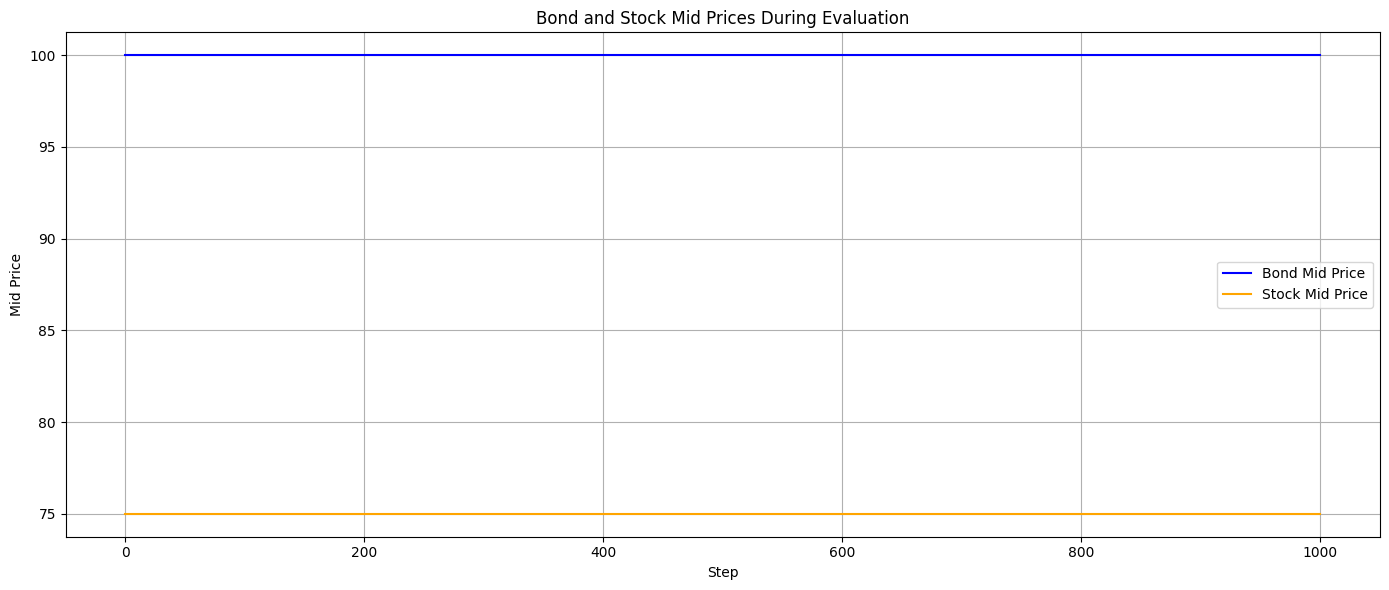

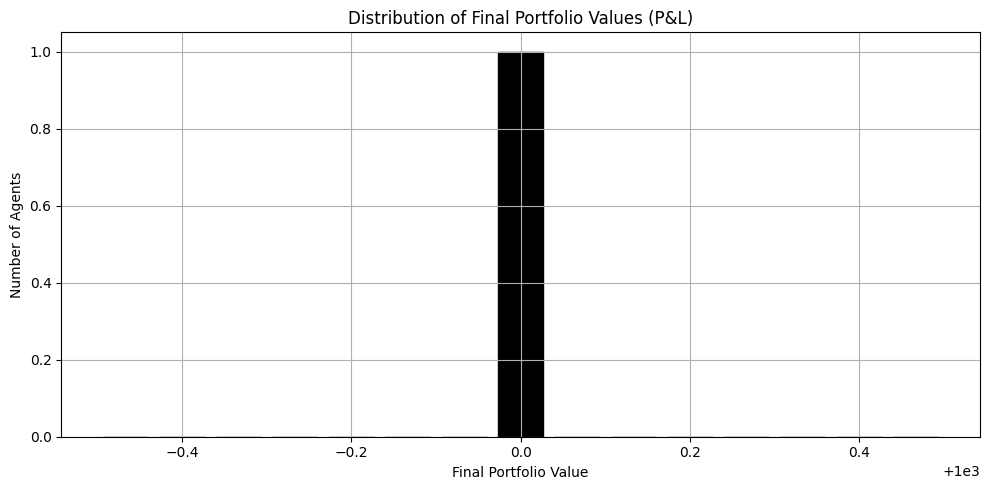

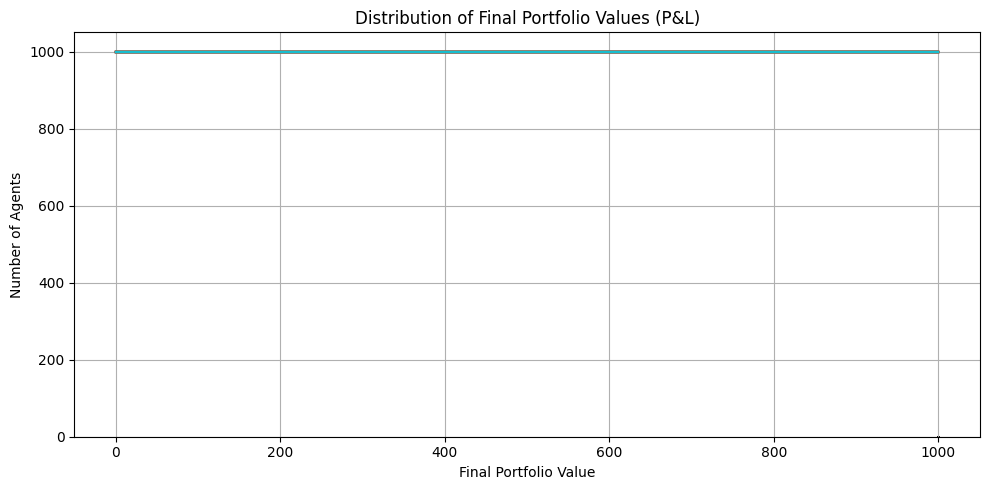

In [66]:
import matplotlib.pyplot as plt

# Paths
MODEL_PATH = "./v4/ppo_trading_final"

# 1. Load environment and wrap it exactly the same way
eval_env = ParallelTradingEnv(agent_count=AGENT_COUNT)
eval_env = ss.pettingzoo_env_to_vec_env_v1(eval_env)
eval_env = ss.concat_vec_envs_v1(
    eval_env, num_vec_envs=1, num_cpus=1, base_class="stable_baselines3"
)

# 2. Load trained model
# model = PPO.load(MODEL_PATH, env=eval_env)

# 3. Reset environment
obs = eval_env.reset()

# 4. Storage for plotting
bond_midpoints = []
stock_midpoints = []
portfolio_values = {agent_id: [] for agent_id in range(AGENT_COUNT)}

done = False

# 5. Run one full evaluation episode
while not done:
    # 5a. Predict actions
    action, _states = model.predict(obs, deterministic=True)
    
    # 5b. Step environment
    obs, rewards, dones, infos = eval_env.step(action)

    # 5c. Mid price extraction from observation
    # observations are a list with 1 env -> list of dicts for each agent
    bond_midpoint = obs["bond_midpoint_price"][0]
    stock_midpoint = obs["stock_midpoint_price"][0]
    bond_midpoints.append(bond_midpoint)
    stock_midpoints.append(stock_midpoint)

    # 5d. Portfolio tracking (only last known cash/bond/stock positions)
    for agent_id in range(AGENT_COUNT):
        cash, bond_pos, stock_pos = obs["positions"][agent_id]
        portfolio_value = (
            cash
            + bond_pos * bond_midpoint
            + stock_pos * stock_midpoint
        )
        portfolio_values[agent_id].append(portfolio_value)
        print(agent_id, portfolio_value, obs["positions"][agent_id])

    done = dones[0]  # vectorized env with 1 env, so index 0

# 6. Final P&L for each agent
final_pnls = [portfolio_values[agent_id][-1] for agent_id in range(AGENT_COUNT)]

# 7. Plotting results

# 7a. Mid price plots
plt.figure(figsize=(14,6))
plt.plot(bond_midpoints, label="Bond Mid Price", color="blue")
plt.plot(stock_midpoints, label="Stock Mid Price", color="orange")
plt.xlabel("Step")
plt.ylabel("Mid Price")
plt.title("Bond and Stock Mid Prices During Evaluation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7b. P&L histogram
plt.figure(figsize=(10,5))
plt.hist(final_pnls, bins=15, edgecolor='black')
plt.xlabel("Final Portfolio Value")
plt.ylabel("Number of Agents")
plt.title("Distribution of Final Portfolio Values (P&L)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
for agent_id, portfolio_value_list in portfolio_values.items():
    plt.plot(portfolio_value_list, label=f"Agent {agent_id} Value")
    pass
plt.hist(final_pnls, bins=15, edgecolor='black')
plt.xlabel("Final Portfolio Value")
plt.ylabel("Number of Agents")
plt.title("Distribution of Final Portfolio Values (P&L)")
plt.grid(True)
plt.tight_layout()
plt.show()